# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from comp451.classifiers.cnn import *
from comp451.data_utils import get_CIFAR10_data
from comp451.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from comp451.layers import *
from comp451.fast_layers import *
from comp451.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `comp451/layers.py`,
 implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.
Please do not flip the filter during convolution.
You can test your implementation by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.


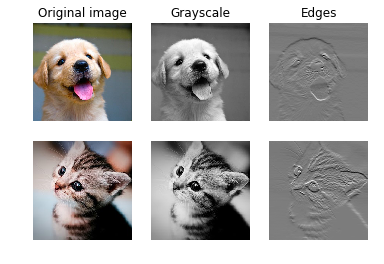

In [4]:
from imageio import imread
from PIL import Image
    
kitten = imread('notebook_images/kitten.jpg')
puppy = imread('notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Convolution: Naive backward pass
We provided the backward pass for the convolution operation in the function `conv_backward_naive` in the 
file `comp451/layers.py`. Note that this is not a particularly efficient implementation.
Please review the function so that you are familiar with it.
You can use the following to check the backward pass with a numeric gradient check.

In [5]:
np.random.seed(451)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# The errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  2.647600382630047e-08
dw error:  7.75528342529715e-10
db error:  1.5537461485686853e-10


# Max-Pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `comp451/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [6]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Max-Pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `comp451/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [7]:
np.random.seed(451)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.2756341469682274e-12


# Average-Pooling: Naive forward
Implement the forward pass for the average-pooling operation in the function `avg_pool_forward_naive` in the file `comp451/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [8]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = avg_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.28157895, -0.26684211],
                         [-0.22263158, -0.20789474]],

                        [[-0.16368421, -0.14894737],
                         [-0.10473684, -0.09      ]],

                        [[-0.04578947, -0.03105263],
                         [ 0.01315789,  0.02789474]]],


                       [[[ 0.07210526,  0.08684211],
                         [ 0.13105263,  0.14578947]],

                        [[ 0.19      ,  0.20473684],
                         [ 0.24894737,  0.26368421]],

                        [[ 0.30789474,  0.32263158],
                         [ 0.36684211,  0.38157895]]]])

# Compare your output with ours. Difference should be on the order of e-7.
print('Testing avg function:')
print('difference: ', rel_error(out, correct_out))

Testing avg function:
difference:  1.8000003183688645e-07


# Average-Pooling: Naive backward
Implement the backward pass for the avg-pooling operation in the function `avg_pool_backward_naive` in the file `comp451/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [9]:
np.random.seed(451)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: avg_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = avg_pool_forward_naive(x, pool_param)
dx = avg_pool_backward_naive(dout, cache)

# Your error should be on the order of e-11
print('Testing avg_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing avg_pool_backward_naive function:
dx error:  1.8928936583652675e-11


## Inline Question 1: 

Comparing the max-pool and average-pool operations from a theoretical perspective, which one would you choose if you are developing a computer vision application? What is your motivation to choose one over the other?

## Answer:

Max pooling is better with edge detection, because edges have higher values, but if i want a smoother image then I would use average pooling. However the paper [Learning Deep Features for Discriminative Localization] states that average pooling may give better localization over all image.

# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `comp451/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `comp451` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [29]:
# Rel errors should be around e-9 or less
from comp451.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(451)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 6.491511s
Fast: 0.007555s
Speedup: 859.259917x
Difference:  1.837404876056675e-09

Testing conv_backward_fast:
Naive: 4.663224s
Fast: 0.008417s
Speedup: 554.000312x
dx difference:  4.230275118334904e-11
dw difference:  1.9987071458735473e-13
db difference:  2.403642724476473e-15


In [30]:
# Relative errors should be close to 0.0
from comp451.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(451)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.017097s
fast: 0.001460s
speedup: 11.713656x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.075214s
fast: 0.009948s
speedup: 7.560309x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `comp451/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks. Run the cells below to sanity check they're working.

In [12]:
# conv - lrelu - pool
from comp451.layer_utils import conv_lrelu_pool_forward, conv_lrelu_pool_backward
np.random.seed(451)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
lrelu_param = {'alpha': -2e-3}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_lrelu_pool_forward(x, w, b, conv_param, lrelu_param, pool_param)
dx, dw, db = conv_lrelu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_lrelu_pool_forward(x, w, b, conv_param, lrelu_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_lrelu_pool_forward(x, w, b, conv_param, lrelu_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_lrelu_pool_forward(x, w, b, conv_param, lrelu_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_leakyRelu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_leakyRelu_pool
dx error:  3.1730426797085436e-08
dw error:  1.8671032915282574e-09
db error:  1.5134430108846995e-10


In [13]:
# conv - lrelu
from comp451.layer_utils import conv_lrelu_forward, conv_lrelu_backward
np.random.seed(451)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
lrelu_param = {'alpha': 1e-2}

out, cache = conv_lrelu_forward(x, w, b, conv_param, lrelu_param)
dx, dw, db = conv_lrelu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_lrelu_forward(x, w, b, conv_param, lrelu_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_lrelu_forward(x, w, b, conv_param, lrelu_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_lrelu_forward(x, w, b, conv_param, lrelu_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_leakyRelu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))


Testing conv_leakyRelu:
dx error:  2.028517330568422e-08
dw error:  1.4024908188080693e-09
db error:  2.0828569691193637e-11


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `comp451/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [27]:
model = ThreeLayerConvNet()
print(model.params['W1'].shape)
print(model.params['b1'].shape)
print(model.params['W2'].shape)
print(model.params['b2'].shape)
print(model.params['W3'].shape)
print(model.params['b3'].shape)

(32, 3, 7, 7)
(32,)
(8192, 100)
(100,)
(100, 10)
(10,)


In [28]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025827790566673
Initial loss (with regularization):  2.508807906620479


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [22]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(451)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.631966e-04
W2 max relative error: 3.623524e-02
W3 max relative error: 2.250541e-02
b1 max relative error: 2.311306e-05
b2 max relative error: 7.472646e-05
b3 max relative error: 1.793759e-09


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [23]:
np.random.seed(451)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.348029
(Epoch 0 / 15) train acc: 0.170000; val_acc: 0.126000
(Iteration 2 / 30) loss: 3.699891
(Epoch 1 / 15) train acc: 0.220000; val_acc: 0.148000
(Iteration 3 / 30) loss: 3.086443
(Iteration 4 / 30) loss: 2.493122
(Epoch 2 / 15) train acc: 0.310000; val_acc: 0.144000
(Iteration 5 / 30) loss: 2.157064
(Iteration 6 / 30) loss: 2.060644
(Epoch 3 / 15) train acc: 0.280000; val_acc: 0.154000
(Iteration 7 / 30) loss: 2.258876
(Iteration 8 / 30) loss: 1.848294
(Epoch 4 / 15) train acc: 0.450000; val_acc: 0.189000
(Iteration 9 / 30) loss: 1.806960
(Iteration 10 / 30) loss: 1.476516
(Epoch 5 / 15) train acc: 0.450000; val_acc: 0.160000
(Iteration 11 / 30) loss: 1.362435
(Iteration 12 / 30) loss: 1.591598
(Epoch 6 / 15) train acc: 0.550000; val_acc: 0.189000
(Iteration 13 / 30) loss: 1.531086
(Iteration 14 / 30) loss: 1.464104
(Epoch 7 / 15) train acc: 0.640000; val_acc: 0.189000
(Iteration 15 / 30) loss: 1.293942
(Iteration 16 / 30) loss: 1.029674
(Epoch 8 / 15) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

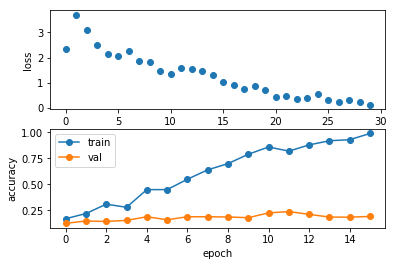

In [24]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [25]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, alpha=1e-2)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304503
(Epoch 0 / 1) train acc: 0.117000; val_acc: 0.119000
(Iteration 21 / 980) loss: 2.106046
(Iteration 41 / 980) loss: 1.903467
(Iteration 61 / 980) loss: 1.834456
(Iteration 81 / 980) loss: 1.925821
(Iteration 101 / 980) loss: 2.150829
(Iteration 121 / 980) loss: 1.943916
(Iteration 141 / 980) loss: 2.182821
(Iteration 161 / 980) loss: 1.776973
(Iteration 181 / 980) loss: 1.919248
(Iteration 201 / 980) loss: 2.079267
(Iteration 221 / 980) loss: 2.314128
(Iteration 241 / 980) loss: 1.598467
(Iteration 261 / 980) loss: 1.789444
(Iteration 281 / 980) loss: 1.916577
(Iteration 301 / 980) loss: 1.970404
(Iteration 321 / 980) loss: 2.075838
(Iteration 341 / 980) loss: 1.746866
(Iteration 361 / 980) loss: 2.169126
(Iteration 381 / 980) loss: 1.836137
(Iteration 401 / 980) loss: 1.673002
(Iteration 421 / 980) loss: 1.760428
(Iteration 441 / 980) loss: 1.930903
(Iteration 461 / 980) loss: 1.909341
(Iteration 481 / 980) loss: 1.662626
(Iteration 501 / 980) loss: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

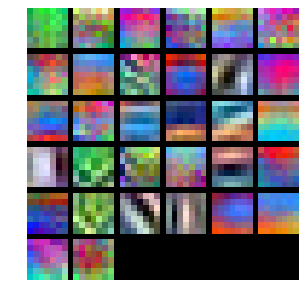

In [26]:
from comp451.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()